In [1]:
import os
import json
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from torchvision import datasets, transforms
import pandas as pd

### Configuring Environment

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_palette(sns.color_palette(palette='twilight_shifted'))

### Dataset preparation

In [3]:
data = []
with open('data_tp1', 'r') as file:
    for line in file:
        values = line.split(',')
        label = int(values[0])
        image = np.array([int(x) for x in values[1:]]).reshape((28, 28))
        data.append((torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.uint8)))

train_split = 0.85
split_idx = int(len(data) * train_split)
train_data = data[0:split_idx]
test_data = data[split_idx:]

print(f"len - train data: {len(train_data)}, test data: {len(test_data)}")

len - train data: 4250, test data: 750


In [4]:
class MNISTDatasetTRAIN(Dataset):
    def __init__(self):
        self.data = train_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.to(device), label.to(device)
    
    
class MNISTDatasetTEST(Dataset):
    def __init__(self):
        self.data = test_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.to(device), label.to(device)
    
    
dataset_train = MNISTDatasetTRAIN()
dataset_test = MNISTDatasetTEST()

### Model definition

In [5]:
class MNISTModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Sigmoid(),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
        ) 
        
    def forward(self, x):
        return self.layers(x)

### Training loops

#### Gradient Descent
Run through all samples and then update -> batch_size is the whole dataset len

#### Stochastic Gradient Descent
After every sample the optimizer is called

#### Mini batch
Run through a batch with a certain number of samples and then the optmizer is called

In [6]:
loss_fn = nn.CrossEntropyLoss()

num_epochs = 50

# Training functions
def train_gradient_descent(model, dataset, learning_rate, num_epochs):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
    min_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()

        for data, target in train_loader:
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            total_loss += loss.item()

        optimizer.step()
        avg_loss = total_loss / len(train_loader)
        min_loss = min(min_loss, avg_loss)
        
        if epoch == num_epochs-1:
            print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    
    return min_loss

def train_stochastic_gradient_descent(model, dataset, learning_rate, num_epochs):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    min_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        min_loss = min(min_loss, avg_loss)
        
        if epoch == num_epochs-1:
            print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    
    return min_loss

def train_mini_batch(model, dataset, learning_rate, num_epochs, batch_size):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    min_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        min_loss = min(min_loss, avg_loss)
        
        if epoch == num_epochs-1:
            print(f'Epoch {epoch+1}, Loss: {avg_loss}')
    
    return min_loss

### Helper functions for saving and config

In [7]:
class ModelParams:
    def __init__(self, method: str, hidden_size: int, learning_rate: float, batch_size: int, loss: float):
        self.method = method
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.loss = loss

    def to_dict(self):
        return {
            "method": self.method,
            "hidden_size": self.hidden_size,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "loss": self.loss
        }
        
def save_model(model, dir_name, file_name, params: ModelParams = None):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    torch.save(model.state_dict(), os.path.join(dir_name, file_name))
    if params:
        with open(os.path.join(dir_name, file_name + '.json'), 'w') as f:
            json.dump(params.to_dict(), f)


In [8]:
config = {
    "hidden_size": [25, 50, 100],
    "learning_rate": [0.5, 1, 10],
    'batch_size': [10, 50]
}

output_size = 10
input_size = 28*28

best_model = None
lowest_loss = float('inf')
best_params: ModelParams = None

### Training loop properly

In [9]:
# True to train the model (again)
# False instead
train = False

In [10]:
if train:
    for hidden_size in config['hidden_size']:
        for learning_rate in config['learning_rate']:

            print(f'Hidden Size: {hidden_size}, Learning Rate: {learning_rate}')
            model = MNISTModel(input_size, hidden_size, output_size)
            
            loss = train_gradient_descent(model, dataset_train, learning_rate, num_epochs)
            params = ModelParams('Gradient Descent', hidden_size, learning_rate, len(dataset_train), loss)
            save_model(model, 'models', f'GD_hidden{hidden_size}_lr{learning_rate}.pt', params)
            if loss < lowest_loss:
                lowest_loss = loss
                best_model = model
                best_params = params


            loss = train_stochastic_gradient_descent(model, dataset_train, learning_rate, num_epochs)
            params = ModelParams('Stochastic Gradient Descent', hidden_size, learning_rate, 1, loss)
            save_model(model, 'models', f'SGD_hidden{hidden_size}_lr{learning_rate}.pt', params)
            if loss < lowest_loss:
                lowest_loss = loss
                best_model = model
                best_params = params


            for batch_size in config['batch_size']:
                print(f'Mini-Batch Gradient Descent with Batch Size: {batch_size}')
                model = MNISTModel(input_size, hidden_size, output_size)
                loss = train_mini_batch(model, dataset_train, learning_rate, num_epochs, batch_size)
                params = ModelParams('Mini-Batch Gradient Descent', hidden_size, learning_rate, batch_size, loss)
                save_model(model, 'models', f'MBGD_hidden{hidden_size}_lr{learning_rate}_bs{batch_size}.pt', params)
                if loss < lowest_loss:
                    lowest_loss = loss
                    best_model = model
                    best_params = params

    save_model(best_model, 'models', 'best_model.pt', best_params)
    print('Best model saved with lowest loss:', lowest_loss)
    print('Best model parameters:', best_params.to_dict())

### Load best model

In [11]:
def load_model(model_class, filename, input_size, hidden_size, output_size):
    model = model_class(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(filename, map_location=device))
    return model

def load_model_params(filename):
    with open(filename, 'r') as f:
        params_dict = json.load(f)
    return ModelParams(**params_dict)

def load_best_model():
    best_params = load_model_params('models/best_model.pt.json')
    return load_model(MNISTModel, 'models/best_model.pt', input_size, best_params.hidden_size, output_size)

best_model = load_best_model().to(device)

### Testing in Test Dataset

Accuracy of the model on the test images: 89.73%


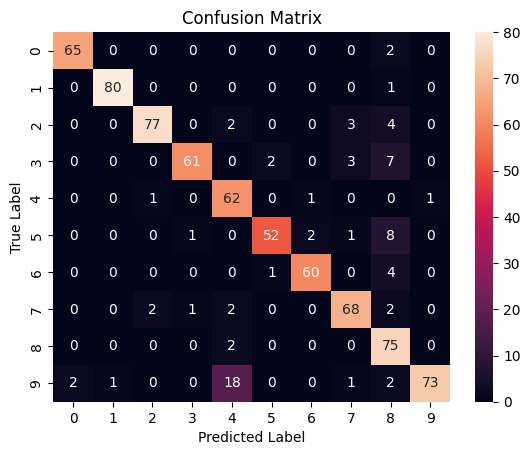

In [12]:
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = best_model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Testing in Dataset drawn by me and compare to MNIST Test Dataset

In [13]:
import os
from PIL import Image, ImageOps, ImageFilter, ImageEnhance

input_dir = 'drawings'
output_dir = 'processed_drawings'

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)

        inverted_image = ImageOps.invert(image.convert('RGB'))

        blurred_image = inverted_image.filter(ImageFilter.GaussianBlur(radius=0.75))

        enhancer = ImageEnhance.Brightness(blurred_image)
        amplified_image = enhancer.enhance(3)
        blurred_amplified_image = amplified_image.filter(ImageFilter.GaussianBlur(radius=0.5))

        output_path = os.path.join(output_dir, filename)
        blurred_amplified_image.save(output_path)

In [14]:
class DrawingsDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in range(10):
            file_path = os.path.join(image_dir, f'drawn_digit_{label}.png')
            if os.path.exists(file_path):
                self.image_paths.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image.to(device), torch.tensor(label).to(device)

image_dir = 'processed_drawings'
drawings_dataset = DrawingsDataset(image_dir, transform=transforms.ToTensor())
drawings_dataloader = DataLoader(drawings_dataset, batch_size=1, shuffle=True)

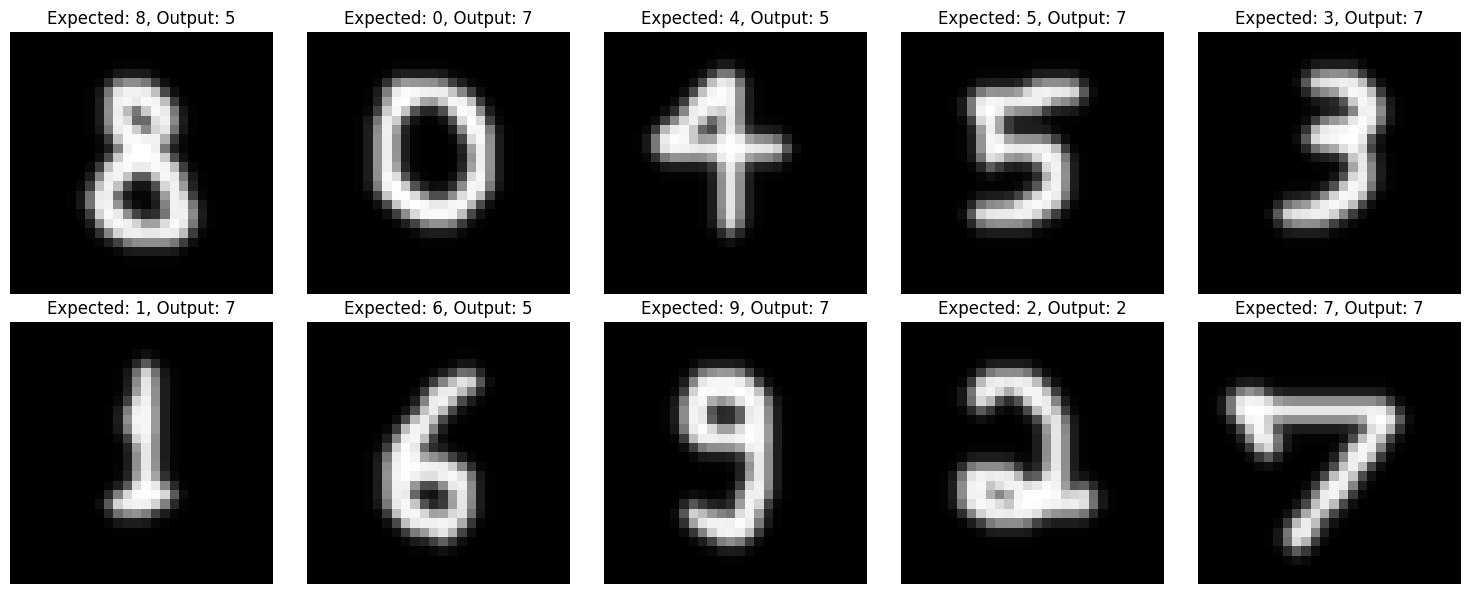

Accuracy of the model on the 10 images: 20.00%


In [15]:
def test_model(model, test_loader, mod=5):
    model.eval()
    correct = 0
    total = 0
    
    count = 0
    images_to_plot = []
    labels_to_plot = []
    predictions_to_plot = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1
            
            if count % mod == 0:
                images_to_plot.append(images[0].cpu())
                labels_to_plot.append(labels[0].item())
                predictions_to_plot.append(predicted[0].item())
            
            if len(images_to_plot) >= 10:  # only the first 10 predictions for visualization
                break
            
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images_to_plot):
            ax.imshow(images_to_plot[i].squeeze(), cmap='gray')
            ax.set_title(f'Expected: {labels_to_plot[i]}, Output: {predictions_to_plot[i]}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Accuracy of the model on the 10 images: {100 * correct / total:.2f}%')

test_model(best_model, drawings_dataloader, mod=1)

### Agora nos dados de teste para visualização

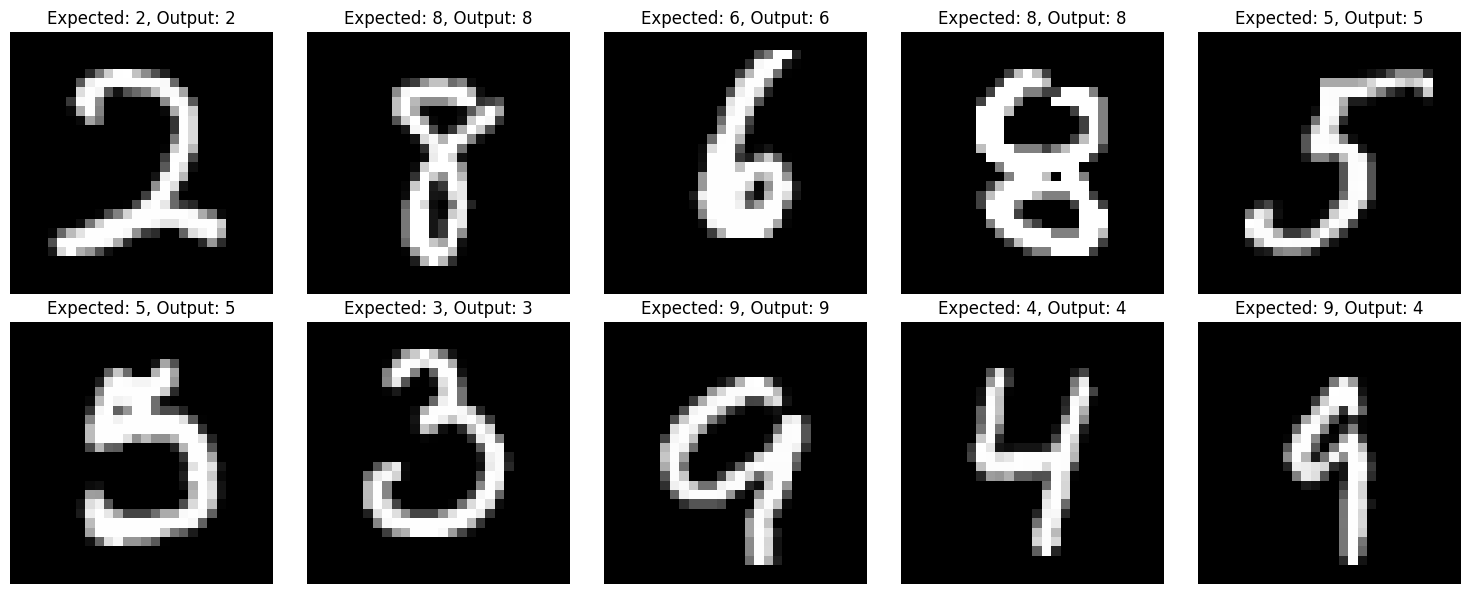

Accuracy of the model on the 10 images: 90.00%


In [16]:
test_loader_batch_1 = DataLoader(dataset_test, batch_size=1)
test_model(best_model, test_loader_batch_1, mod=1)

#### Considerações

Apesar dos números aparentarem pouco diferentes visualmente, o modelo de rede neural não performou bem nos dados que desenhei e fiz um pré-processamento

Isso indica uma tendência de má generalização do modelo

### Evaluating models

In [17]:
directory = './models'

data = []

def load_data(filename):
    try:
        with open(filename, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

for filename in os.listdir(directory):
    if filename.endswith('.pt.json') and filename != 'best_model.pt.json':
        file_data = load_data(os.path.join(directory, filename))
        if file_data:
            data.append(file_data)

df = pd.DataFrame(data)

grouped_df = df.groupby(['method', 'hidden_size', 'learning_rate', 'batch_size']).mean().reset_index()
grouped_df.head()

,method,hidden_size,learning_rate,batch_size,loss
0,Gradient Descent,25,0.5,4250,1.878064
1,Gradient Descent,25,1.0,4250,1.879310
2,Gradient Descent,25,10.0,4250,2.296191
3,Gradient Descent,50,0.5,4250,1.781994
4,Gradient Descent,50,1.0,4250,1.929094


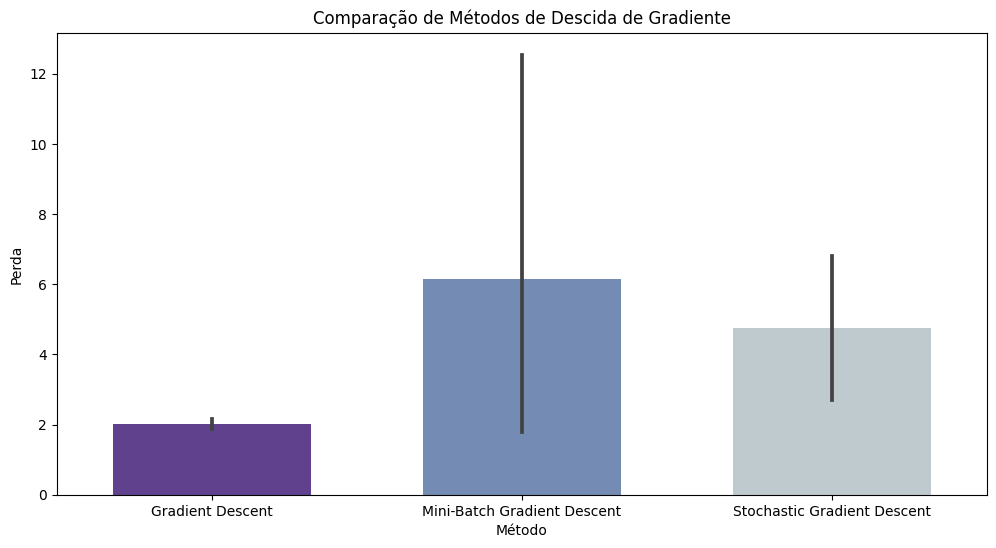

In [18]:
plt.figure(figsize=(12, 6))

sns.barplot(x='method', y='loss', data=grouped_df)

plt.xlabel('Método')
plt.ylabel('Perda')
plt.title('Comparação de Métodos de Descida de Gradiente')

for item in plt.gca().patches:
    current_width = item.get_width()
    item.set_width(current_width * 0.8)
    item.set_x(item.get_x() + current_width * 0.1)


plt.show()

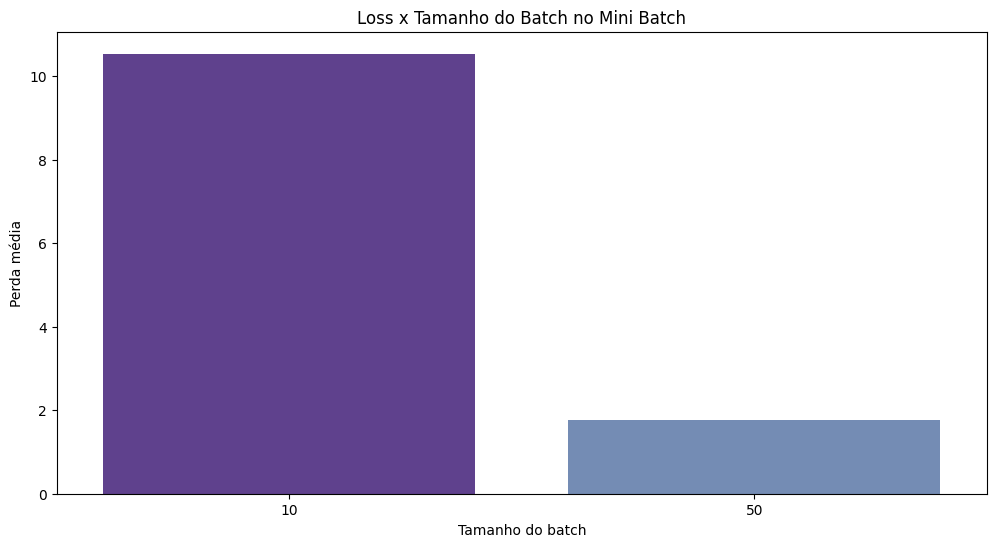

In [20]:
mini_batch_df_bs = df[df['method'] == 'Mini-Batch Gradient Descent'].groupby('batch_size').mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(x='batch_size', y='loss', data=mini_batch_df_bs)

plt.xlabel('Tamanho do batch')
plt.ylabel('Perda média')
plt.title('Loss x Tamanho do Batch no Mini Batch')

plt.show()

Nesse gráfico, aparenta que o tamanho do batch de 10 apresentou um desempenho pior, mas no gráfico seguinte é perceptível o que aconteceu

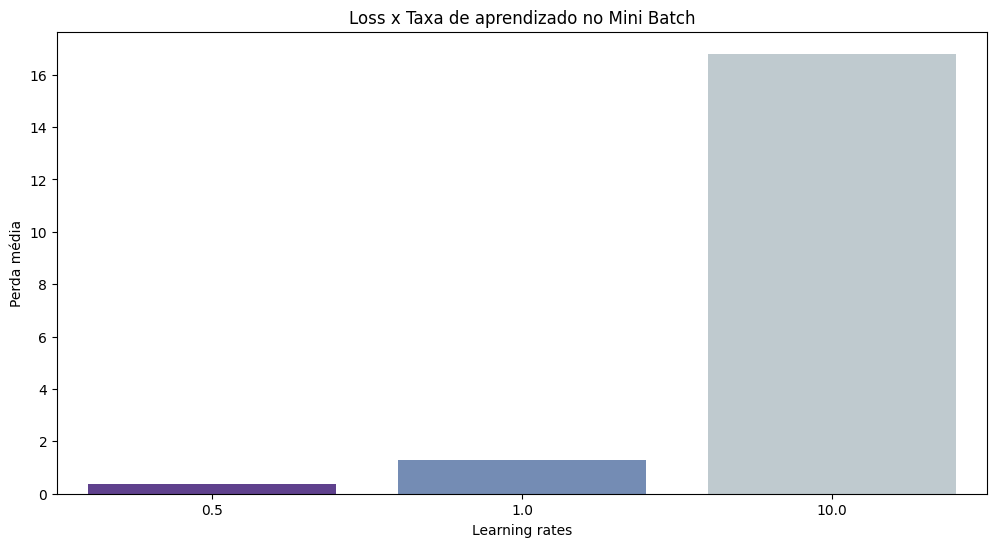

In [21]:
mini_batch_df_lr = df[df['method'] == 'Mini-Batch Gradient Descent'].groupby('learning_rate').mean().reset_index()
mini_batch_df_lr

plt.figure(figsize=(12, 6))

sns.barplot(x='learning_rate', y='loss', data=mini_batch_df_lr)

plt.xlabel('Learning rates')
plt.ylabel('Perda média')
plt.title('Loss x Taxa de aprendizado no Mini Batch')

plt.show()

O Learning Rate alto de 10 é extremamente prejudicial. Mas como isso afetaria no gráfico do tamanho do batch?

Simples: quanto maior a taxa de aprendizado, os batches menores serão mais suscetíveis à uma atualização "ruim" do gradiente, pois estarão enviezadas.

Um fato curioso é que se o tamanho do batch é 1, ou seja, no caso do SGD, essa variação é um pouco mais branda. Isso pode ser devido à uma variação mais frequente do gradiente, de maneira que as atualizações pontuais "certas" cancelem as "erradas" e vice-versa. 

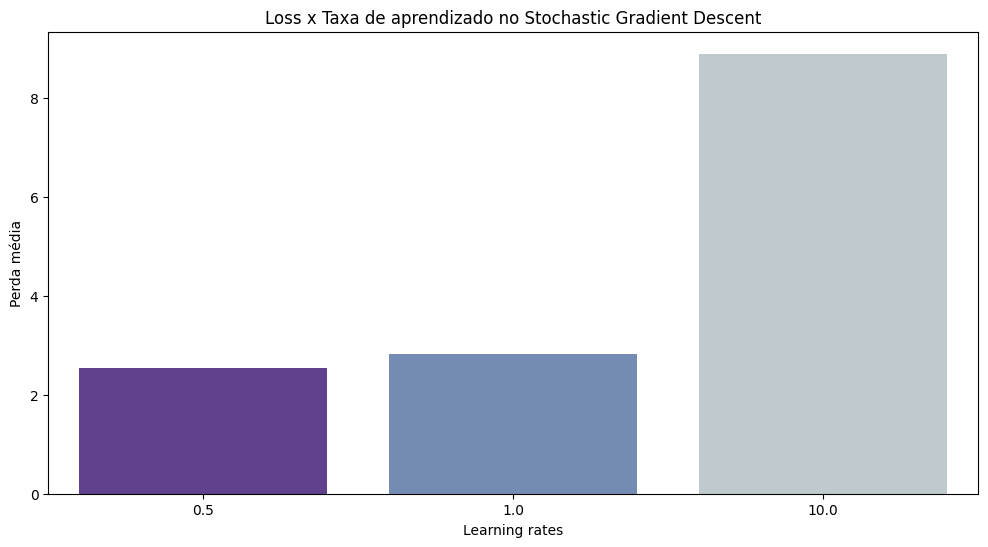

In [23]:
mini_batch_df_lr = df[df['method'] == 'Stochastic Gradient Descent'].groupby('learning_rate').mean().reset_index()
mini_batch_df_lr

plt.figure(figsize=(12, 6))

sns.barplot(x='learning_rate', y='loss', data=mini_batch_df_lr)

plt.xlabel('Learning rates')
plt.ylabel('Perda média')
plt.title('Loss x Taxa de aprendizado no Stochastic Gradient Descent')

plt.show()

Como explicado anteriormente, o SGD também sofre do mesmo problema, porém de maneira levemente mais branda.

No Gradiente Descendente tradicional, é esperado e visto na prática que ele não sofra tanta variação, devido a computação de todos os gradientes dos dados antes de uma atualização.